In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras import layers

In [2]:
# a)
current_dir = os.path.abspath("")
data_dir = os.path.abspath("../data/E2")

current_dir, data_dir

('c:\\KODA\\ITHS\\9_Deep Learning\\DeepLearning\\exercises',
 'c:\\KODA\\ITHS\\9_Deep Learning\\DeepLearning\\data\\E2')

(120, 120, 4)

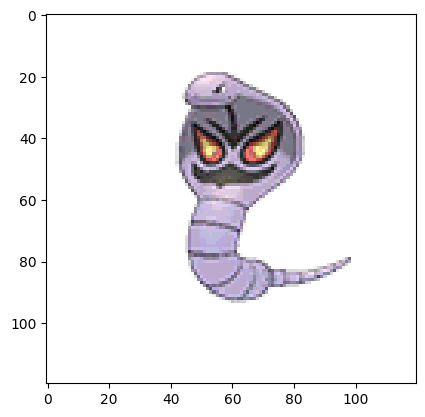

In [3]:
sample_img = plt.imread(os.path.join(data_dir, "images/arbok.png"))
plt.imshow(sample_img)
sample_img.shape

In [4]:
# b)
df = pd.read_csv(os.path.join(data_dir, "pokemon.csv"))

In [5]:
df.head()

,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard


In [6]:
display(df["Type1"].value_counts().sort_index())
display(df["Type2"].value_counts().sort_index())

Type1
Bug          72
Dark         29
Dragon       27
Electric     40
Fairy        18
Fighting     29
Fire         53
Flying        3
Ghost        27
Grass        78
Ground       32
Ice          23
Normal      105
Poison       34
Psychic      53
Rock         46
Steel        26
Water       114
Name: count, dtype: int64

Type2
Bug          5
Dark        17
Dragon      18
Electric     8
Fairy       29
Fighting    25
Fire        11
Flying      95
Ghost       16
Grass       19
Ground      32
Ice         11
Normal       4
Poison      32
Psychic     29
Rock        14
Steel       23
Water       17
Name: count, dtype: int64

In [7]:
df["Type"] = list(zip(df["Type1"], df["Type2"].fillna("")))
df.head()

,Name,Type1,Type2,Evolution,Type
0,bulbasaur,Grass,Poison,ivysaur,"(Grass, Poison)"
1,ivysaur,Grass,Poison,venusaur,"(Grass, Poison)"
2,venusaur,Grass,Poison,NaN,"(Grass, Poison)"
3,charmander,Fire,NaN,charmeleon,"(Fire, )"
4,charmeleon,Fire,NaN,charizard,"(Fire, )"


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       809 non-null    object
 1   Type1      809 non-null    object
 2   Type2      405 non-null    object
 3   Evolution  32 non-null     object
 4   Type       809 non-null    object
dtypes: object(5)
memory usage: 31.7+ KB


In [43]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.2, 0.2),
    ]
)

In [42]:
inputs = keras.Input(shape=(120, 120, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 5, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(18, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [18]:
sorted_and_split_dir = os.path.join(data_dir, "split_sorted_to_types")

for dir_type in ["train", "validation", "test"]:
    os.makedirs(os.path.join(sorted_and_split_dir, dir_type), exist_ok=True)
    
    for poke_type in df["Type1"].unique():
        os.makedirs(os.path.join(sorted_and_split_dir, dir_type, poke_type), exist_ok=True)

    train_sort_path = os.path.join(sorted_and_split_dir, "train")
    validation_sort_path = os.path.join(sorted_and_split_dir, "validation")
    test_sort_path = os.path.join(sorted_and_split_dir, "test")

    # for pokemon in df["Name"]:
    #     img = plt.imread(os.path.join(data_dir, "images", f"{pokemon}.png"))
    #     img = img[:, :, :3]
    
    #     if np.random.rand() < 0.7:
    #         plt.imsave(os.path.join(train_sort_path, df.loc[df["Name"] == pokemon, "Type1"].values[0], f"{pokemon}.png"), img)
    #     elif 0.7 < np.random.rand() < 0.9:
    #         plt.imsave(os.path.join(validation_sort_path, df.loc[df["Name"] == pokemon, "Type1"].values[0], f"{pokemon}.png"), img)
    #     elif 0.9 < np.random.rand() < 1:
    #         plt.imsave(os.path.join(test_sort_path, df.loc[df["Name"] == pokemon, "Type1"].values[0], f"{pokemon}.png"), img)

In [13]:
# plt.figure(figsize=(10, 10))
# for images in os.listdir(os.path.join(new_dir, "Water"))[:9]:
#     for i in range(9):
#         augmented_images = data_augmentation(np.expand_dims(plt.imread(os.path.join(new_dir, "Water", images)), 0))
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0])
#         plt.axis("off")

In [49]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="first_pokemon_model.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
]

In [50]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [47]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(sorted_and_split_dir, "train"),
    image_size=(120, 120),
    batch_size=16,
)
validation_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(sorted_and_split_dir, "validation"),
    image_size=(120, 120),
    batch_size=16,
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(sorted_and_split_dir, "test"),
    image_size=(120, 120),
    batch_size=16,
)

Found 788 files belonging to 18 classes.
Found 135 files belonging to 18 classes.
Found 62 files belonging to 18 classes.


In [48]:
for data_batch, labels_batch in train_ds:
    print(data_batch.shape, labels_batch.shape)
    break

(16, 120, 120, 3) (16,)


In [54]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=500,
    callbacks=callbacks,
)

Epoch 1/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3057 - loss: 2.1537
Epoch 1: val_loss did not improve from 2.04528
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.3045 - loss: 2.1567 - val_accuracy: 0.2593 - val_loss: 2.1163
Epoch 2/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2870 - loss: 2.1950
Epoch 2: val_loss did not improve from 2.04528
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.2865 - loss: 2.1961 - val_accuracy: 0.2889 - val_loss: 2.0590
Epoch 3/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3162 - loss: 2.1797
Epoch 3: val_loss did not improve from 2.04528
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.3151 - loss: 2.1810 - val_accuracy: 0.2963 - val_loss: 2.0774
Epoch 4/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2595 - loss: 2.2620
Epoch 4: val_loss improved from 2.04528 to 2.03226, saving model to first_pokemon_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.2603 - loss: 2.2610

In [22]:

def plot_metrics(df_history, style='-'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    metrics = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    
    for ax, metrics in zip(ax, metrics):
        df_history.plot(ax=ax, style=style, y=metrics, xlabel='Epoch', ylabel=metrics, title=metrics[0], grid=True)

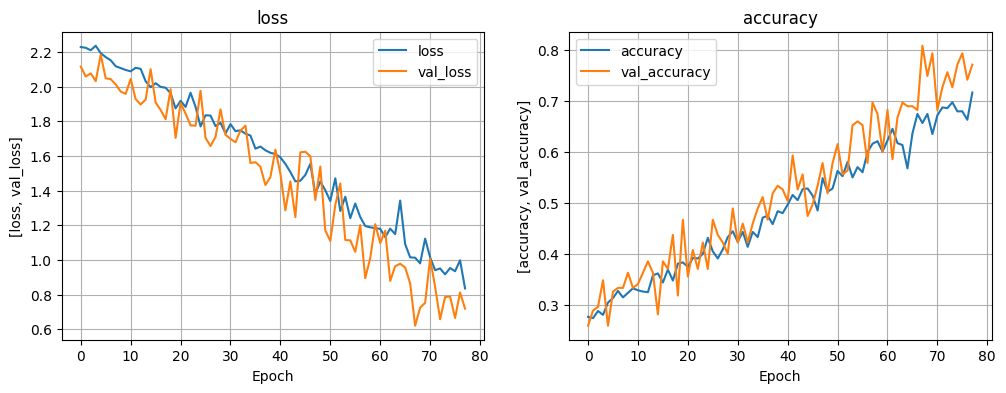

In [55]:
plot_metrics(pd.DataFrame(history.history))

In [56]:
test_model = keras.models.load_model("first_pokemon_model.keras")
test_loss, test_accuracy = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6774 - loss: 1.0146
Test accuracy: 0.6935483813285828
Test loss: 1.0438085794448853
